# SIERPE

## Simulation of the EneRgy PlanE 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import Image

### PMT response

### The SPE class

In [3]:
from scipy import signal as SGN
import numpy as np

In [4]:
from system_of_units import *

In [5]:
import FEParam as FP

In [6]:
# spe is parameterized as an isosceles trapezoid of diagonal 
#   xxxxx-xxxxx      
#           --- 
#         -     -
#       -         -
#     -             -
#   -                 -
#   1 2 3 4 515 4 3 2 1
# x_slope = 5 ns, x_flat = 1 ns

###########################################################
class SPE:

  def __init__(self,pmt_gain=4.5e6,x_slope = 5*ns,x_flat = 1*ns):
    """
    Defines a spe 
    """
    self.pmt_gain=pmt_gain
    self.x_slope=x_slope
    self.x_flat=x_flat
    
    self.spe_base = self.x_slope + self.x_flat
    self.spe_length = 2*self.x_slope + self.x_flat

    self.A=self.pmt_gain*eplus/self.spe_base  #current  
    self.V = self.A*FP.spe_i_to_v()
    self.nADC = int(self.A*FP.spe_i_to_adc())

    self.t = np.arange(0,self.spe_length,FP.time_step)
    nns = int(self.x_slope/FP.time_step)
    nnf = int(self.x_flat/FP.time_step)
    rise = np.linspace(0,self.A, num=nns)
    fall = np.linspace(self.A,0, num=nns)
    flat = self.A*np.ones(nnf)
    self.spe=np.concatenate((rise,flat,fall))
    
        
  def Spe(self):
    """
    Returns a SPE
    """
    return self.t,self.spe

  def SpePulse(self,t0, tmax=1e+6*ns):
    """
    Returns a SPE pulse at time t0
    with baseline extending in steps of time_step from 0 to tmax determined by DELTA_L
    """
    n = int(t0/FP.time_step)
    nmax = int(tmax/FP.time_step)
    if n >= nmax:
      print "error in SpePulse n = %d nmax = %d "%(
        n, nmax)
      sys.exit()

    
    DELTA=np.zeros(nmax)   #Dirac delta of size DELTA_L
    DELTA[n]=1
    step = FP.time_step/ns
    spe_pulse_t =np.arange(0,len(DELTA) + len(self.spe) -1,step)
    spe_pulse = SGN.convolve(DELTA, self.spe)
    
    return spe_pulse_t,spe_pulse

  def SpePulseTrain(self,tlow,tup,tmax=1e+6*ns):
    """
    Returns a train of SPE pulses between tlow and tup separated by tstep
    """
    nmin = int(tlow/FP.time_step)
    nmax = int(tup/FP.time_step)
    NMAX = int(tmax/FP.time_step)
    step = FP.time_step/ns

    if nmax >= NMAX:
      print "error in SpePulse train nmax = %d NMAX = %d "%(
        nmax, NMAX)
      sys.exit()

    DELTA=np.zeros(NMAX)
    DELTA[nmin:nmax+1] = 1
    spe_pulse_t =np.arange(0,len(DELTA) + len(self.spe) -1,step)
    spe_pulse = SGN.convolve(DELTA, self.spe)
      
    return spe_pulse_t,spe_pulse

  def SpePulseFromVectorPE(self,cnt):
    """
    Returns a train of SPE pulses corresponding to vector cnt
    """
    
    spe_pulse = SGN.convolve(cnt[0:-len(self.spe)+1], self.spe)
      
    return spe_pulse

  def __str__(self):
        
    s= """
        SPE:
        Gain = %7.2f I (muA) = %7.2f, V (mV) = %7.2f, ADC = %d
      """%(self.pmt_gain, self.A/microampere, self.V/mV, self.nADC )
    return s


In [7]:
from PlotUtil import *

In [8]:
spe = SPE()
print spe


        SPE:
        Gain = 4500000.00 I (muA) =  120.16, V (mV) =   30.04, ADC = 76
      


In [9]:
signal_start=2000*ns
signal_length=200*microsecond
daq_window = 1*millisecond

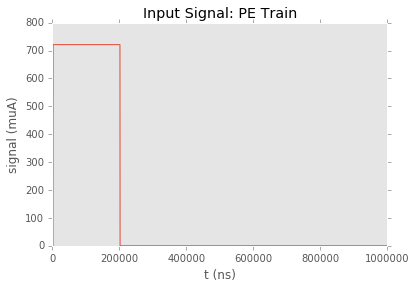

In [10]:
signal_end = signal_start + signal_length
  
signal_t, signal_PE = spe.SpePulseTrain(signal_start,signal_end,daq_window)

plot_signal(signal_t/ns,signal_PE/muA, 
                  title = 'Input Signal: PE Train', 
                  signal_start=0*ns, signal_end=len(signal_t)/ns, 
                  units='muA')

## FEE response

In [11]:
from Util import *

In [12]:
import SPE as SP

In [13]:
def DownScaleSignal(signal_t, signal, scale):
 	"""
 	downscales the time and signal vectors
 	"""
	signal_d=SGN.decimate(signal,scale,ftype='fir')
	signal_t_d = SGN.decimate(signal_t,scale,ftype='fir')

	#pulse_plot(signal_t_d, signal_d)
	return signal_t_d, signal_d

In [14]:
def down_scale_signal_(signal, scale):
 	"""
 	downscales the signal vector. Re-scale the energy
 	"""
	signal_d=SGN.decimate(signal,scale,ftype='fir')
	
	return signal_d*scale

In [15]:
class Filter:

 	def __init__(self,ftype='high',fc=5E3,fs= 1e+9):
		"""
		Defines a Butterworth HPF (high pass frequency) or LPF (low pass frequencey) filter 
		the default sampling frequencey is 1 GHz (inverse of 1 ns time)
		type may be equal to hig or low
		"""
		self.fc = fc
		self.fs = fs
		self.W = 2*self.fc/self.fs
		self.ftype = ftype
		self.b, self.a = SGN.butter(1, self.W, btype=self.ftype, analog=False, output='ba')
		self.ba, self.aa = SGN.butter(1, 2*self.fc, btype=self.ftype, analog=True, output='ba')

	def FilterCoef(self):
		"""
		Returns the filter coefficients
		"""
  		return self.b,self.a

  	def FilterAnalogCoef(self):
		"""
		Returns the filter coefficients
		"""
  		return self.ba,self.aa

	def FilterPulse(self,pulse):
		"""
		Filters a pulse
		"""
  		return SGN.lfilter(self.b,self.a, pulse)

  	def FilterResponse(self):
  		"""
  		Gives the response of the filter y frequency-amplitude
  		"""

  		self.w, self.h = SGN.freqs(self.ba, self.aa)
  		return self.w, self.h


	def __str__(self):
        
		s= """
		Filter:
		fc = %7.2f Hz, fs = %7.2f, W = %7.2f Hz type = %s  
		"""%(self.fc, self.fs, self.W, self.ftype)
		return s

	

In [16]:
class FEE:
	"""
	Emulates the effect of the PMT + FEE:
	1) PMT gain G
	2) A HPF, due to the FEE decoupling capacitor C and the associated series resitor R
	3) A LPF that shapes the signal, with a frequencey f and a noise
	4) A resitor gain RG to transform current in voltage
	"""

 	def __init__(self,PMTG=4.5e6, C=6.75*nF,R= 2350*ohm, 
 				 f=2E6*hertz, fn=2E5*hertz, RG=250*ohm):

 		self.PMTG = PMTG
 		self.C = C
 		self.R = R
 		self.f_LPF = f
 		self.fn_LPF = fn
 		self.RG = RG
 		self.f_HPF=(1./(2*pi*R*C))
 		self.hpf = Filter(ftype='high',fc=self.f_HPF,fs=FP.f_sample)
		self.lpf = Filter(ftype='low',fc=self.f_LPF,fs=FP.f_sample)
		self.hpfr = Filter(ftype='high',fc=self.f_HPF,fs=FP.f_sample_DAQ)


	def Filter(self,signal):
		"""
		for an input signal in pes, returns the effect of the electronics
		"""
		signal_hp = self.hpf.FilterPulse(signal)
  		signal_hp_lp = self.lpf.FilterPulse(signal_hp)
  	
  		return signal_hp, signal_hp_lp

  	def FilterInverse(self, signal):
  		"""
  		Returns the inverse of the HPF filter in bins of 1ns
  		"""
  		b_HPr,a_HPr = self.hpf.FilterCoef()
		h_t_inv = SGN.lfilter(a_HPr,b_HPr, signal)
		return h_t_inv

	def FilterInverseDAQ(self, signal):
		"""
		Returns the inverse of the HPF filter in bins of time_DAQ (25 ns)
		"""
  		b_HPr,a_HPr = self.hpfr.FilterCoef()
		h_t_inv = SGN.lfilter(a_HPr,b_HPr, signal)
		return h_t_inv

	def FEESignal(self,signal_current, noise_rms=0.3*mV):
 		"""
 		filters the input signal according to the filters and transforms it in volts
 		"""
 		signal_hp, signal_hp_lp = self.Filter(signal_current)
 		noise = self.FEENoise(len(signal_current), noise_rms)
 		return signal_hp_lp*self.RG + noise


 	def DAQSignal(self,signal_t, signal_fee, noise_rms=0.3*mV):
 		"""
 		downscale the signal after the FEE
 		
 		"""

		signal_t_d, signal_d = DownScaleSignal(signal_t, signal_fee, int(FP.time_DAQ))
		signal_daq = signal_d/FP.voltsToAdc
		noise = self.FEENoise(len(signal_daq), noise_rms/FP.voltsToAdc)
 		return signal_t_d, signal_daq + noise

 	def daqSignal(self,signal_fee, noise_rms=FP.NOISE_FEE_rms):
 		"""
 		downscale the signal after the FEE
 		
 		"""

		signal_d = down_scale_signal_(signal_fee, int(FP.time_DAQ))
		signal_daq = signal_d/FP.voltsToAdc
		noise = self.FEENoise(len(signal_daq), noise_rms/FP.voltsToAdc)
 		return signal_daq + noise

 	def FEENoise(self, signal_length, noise_rms=FP.NOISE_FEE_rms):
 		"""
 		filters the input signal according to the filters and transforms it in volts
 		"""
 		if noise_rms > 0:
 			noise = np.random.normal(0, noise_rms, signal_length)
 			return noise
 		else:
 			return np.zeros(signal_length)


 	def VSignal(self,signal_current):
 		"""
 		Takes a current input signal and transforms it to volts
 		"""
 		return signal_current*self.RG

 	def InverseSignal(self, signal_t):
 		"""
 		Computes the inverse signal for deconvolution 
 		"""
		pulse = np.zeros(len(signal_t))
		pulse[0]=1
	
		signal_fee_inv = self.FilterInverse(pulse)
		return signal_fee_inv

	def InverseSignalDAQ(self, signal_t):
		"""
		Computes the inverse signal in bins of DAQ
		"""
		pulse = np.zeros(len(signal_t))
		pulse[0]=1
	
		signal_daq_inv = self.FilterInverseDAQ(pulse)
		return signal_daq_inv



 	def __str__(self):
        
		s= """
		NEW FEE
  		PMT gain = %7.2g
  		decoupling capacitor = %7.2f nF
  		decoupling resistor = %7.2f ohm
  		resitor gain = %7.2f ohm
  		HPF frequency = %7.2g Hz  W_HPF = %7.2g 
  		LPF frequency = %7.2g Hz  W_LPF = %7.2g
  		LPF frequency noise = %7.2g Hz  
  """%(self.PMTG,self.C/nF,self.R/ohm, self.RG/ohm,
  		self.f_HPF/hertz,self.hpf.W,
  		self.f_LPF/hertz, self.lpf.W,
  		self.fn_LPF/hertz)
		
		return s



### Single PE response

In [17]:
def SetPlotLabels(xlabel="", ylabel="",grid=True):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if grid == True:
        plt.grid(which='both', axis='both')
    
def single_pe(start_pulse=100*ns, end_pulse=500*ns, noise=FP.NOISE_FEE_rms):
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a single photon (single pe current pulse)
    signal_t, signal_PE =spe.SpePulse(start_pulse, tmax=end_pulse)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.FEESignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))
    
    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe (mV)')
    plt.plot(signal_t, signal_PE_v/mV)
   
    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)
    
    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)
    
    area = np.sum(signal_daq)
    print("adc counts per spe (re-scaled by decimation factor) = {}, not re-scaled = {}".format(area,
                                                                                               area/FP.time_DAQ))
    
    plt.show()


adc counts per spe (re-scaled by decimation factor) = 451.744477067, not re-scaled = 18.0697790827


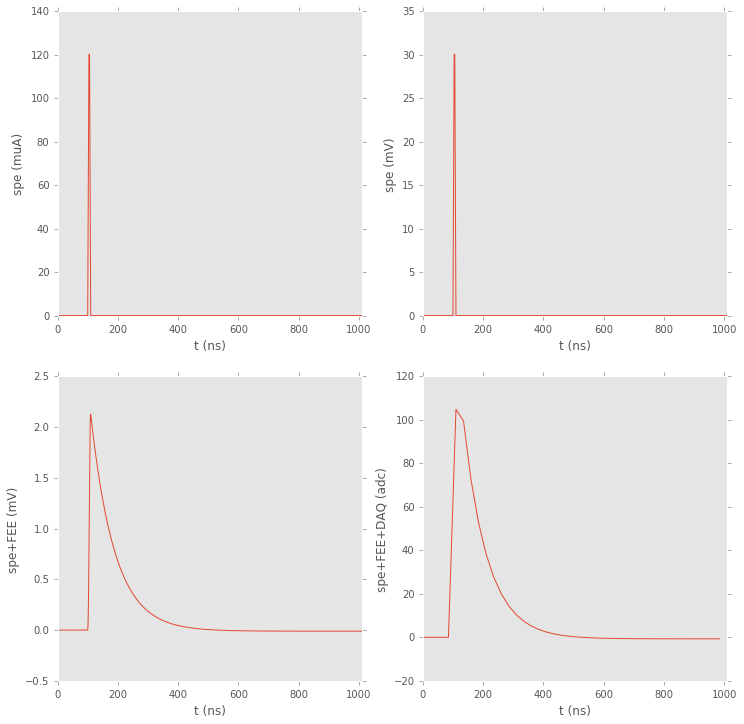

In [18]:
single_pe(start_pulse=100*ns, end_pulse=1000*ns,noise=0)

adc counts per spe (re-scaled by decimation factor) = 494.01286464, not re-scaled = 19.7605145856


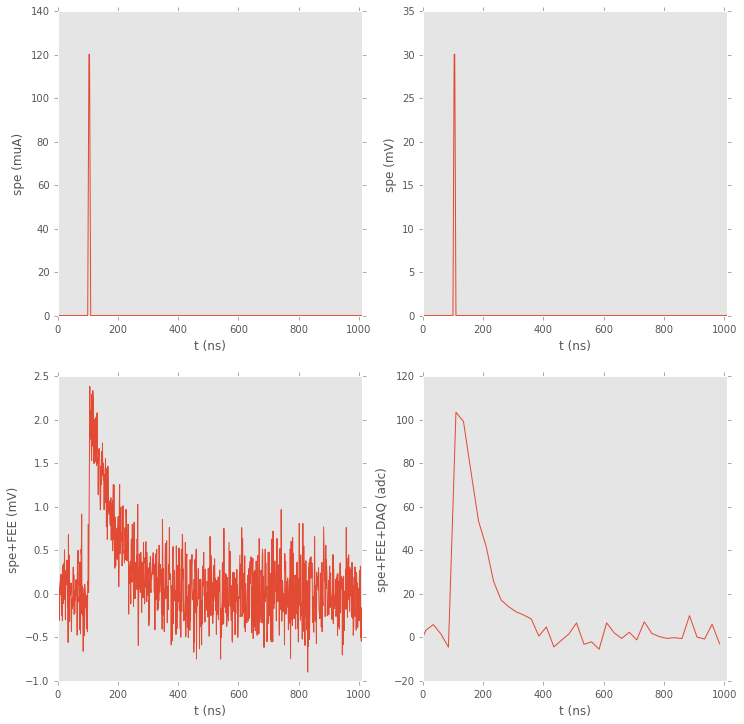

In [19]:
single_pe(start_pulse=100*ns, end_pulse=1000*ns,noise=0.3*mV)

### Photon train response

In [20]:
def pulse_train(signal_start=2000*ns, signal_length=5000*ns, daq_window = 20*microsecond, noise=FP.NOISE_FEE_rms):
    signal_end = signal_start + signal_length
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a photon train 
    signal_t, signal_PE = spe.SpePulseTrain(signal_start,signal_end,daq_window)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.FEESignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))
    
    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe train (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe train (mV)')
    plt.plot(signal_t, signal_PE_v/mV)
   
    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)
    
    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)
    
    area = np.sum(signal_daq)
    print("adc counts per spe = {}".format(area))
    
    plt.show()
    return signal_t, signal_fee



adc counts per spe = 876951.56309


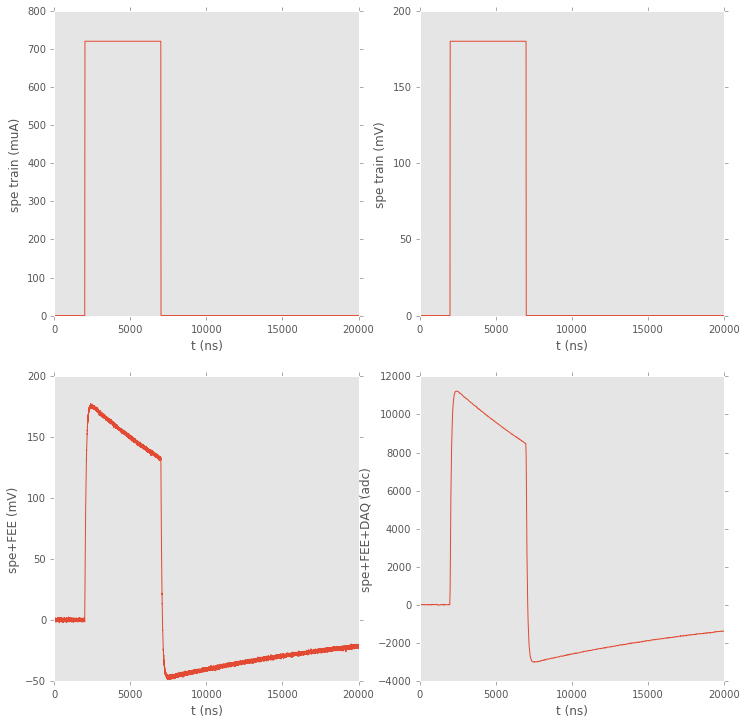

In [21]:
signal_t, signal_fee = pulse_train()

The effect of the differentiation by the HPF is evident!

### Simple deconvolution

In [22]:
noise_DAQ 

NameError: name 'noise_DAQ' is not defined

In [ ]:
	fee = FEE()
	print fee


To deconvolute, one computes the inverse of the signal

In [ ]:
signal_fee_inv = fee.InverseSignal(signal_t)

In [ ]:
plot_signal(signal_t/ns,signal_fee_inv,
                title = 'Inverse FEE', 
                signal_start=0*ns, signal_end=10*ns, 
                units='')

which is a delta function. The corecting coefficient can be taken anywhere after 1

In [ ]:
def DeconvSimple(signal,signal_inv):
	"""
	Deconvolution of the fine-grained fee signal (no DAQ)
	no noise
	using true start and end of signals
	"""

	coef = signal_inv[100]
	
	print "coef = %7.4g"%coef

	acum = np.zeros(len(signal))

	acum[0]=coef*signal[0]
	for n in xrange(1,len(signal)):
		acum[n] = acum[n-1] + signal[n]

	signal_r = signal + coef*acum

	return signal_r

In [ ]:
signal_r = DeconvSimple(signal_fee,signal_fee_inv)

In [ ]:
		plot_signal(signal_t/ns,signal_r/mV,
                	title = 'Deconv simple', 
                	signal_start=0, signal_end=len(signal_t), 
                	units='mV')